In [12]:
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.5.1+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cpu.html
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     ---------------------------------------- 0.0/724.2 kB ? eta -:--:--
     -------------- ------------------------- 262.1/724.2 kB ? eta -:--:--
     -------------------------------------- 724.2/724.2 kB 2.3 MB/s eta 0:00:00


In [10]:
from torch_geometric.datasets import Planetoid
from torchmetrics.classification import Accuracy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [2]:
dataset=Planetoid(root='E:/glass_git/ML-DL/Graph/data',name='Pubmed')
data=dataset[0]

In [3]:
print(f'Dataset: {dataset}')
print('--------------------------')
print(f'number of graph: {len(dataset)}')
print(f'number of nodes: {data.x.shape[0]}')
print(f'number of features: {dataset.num_features}')
print(f'number of classes: {dataset.num_classes}')

print('Graph:')
print('-------')
print(f'Training ndoes: {sum(data.train_mask).item()}')
print(f'Evaluation ndoes: {sum(data.val_mask).item()}')
print(f'Test ndoes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')




Dataset: Pubmed()
--------------------------
number of graph: 1
number of nodes: 19717
number of features: 500
number of classes: 3
Graph:
-------
Training ndoes: 60
Evaluation ndoes: 500
Test ndoes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [4]:
from torch_geometric.loader import NeighborLoader

train_loader=NeighborLoader(
    data,
    num_neighbors=[10,10],
    batch_size=16,
    input_nodes=data.train_mask,
)

In [5]:
for i, subgraph in enumerate(train_loader):
    print(f'subgraph {i} : {subgraph}')

subgraph 0 : Data(x=[490, 500], edge_index=[2, 604], y=[490], train_mask=[490], val_mask=[490], test_mask=[490], n_id=[490], e_id=[604], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
subgraph 1 : Data(x=[289, 500], edge_index=[2, 368], y=[289], train_mask=[289], val_mask=[289], test_mask=[289], n_id=[289], e_id=[368], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
subgraph 2 : Data(x=[363, 500], edge_index=[2, 444], y=[363], train_mask=[363], val_mask=[363], test_mask=[363], n_id=[363], e_id=[444], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
subgraph 3 : Data(x=[237, 500], edge_index=[2, 293], y=[237], train_mask=[237], val_mask=[237], test_mask=[237], n_id=[237], e_id=[293], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[12], batch_size=12)


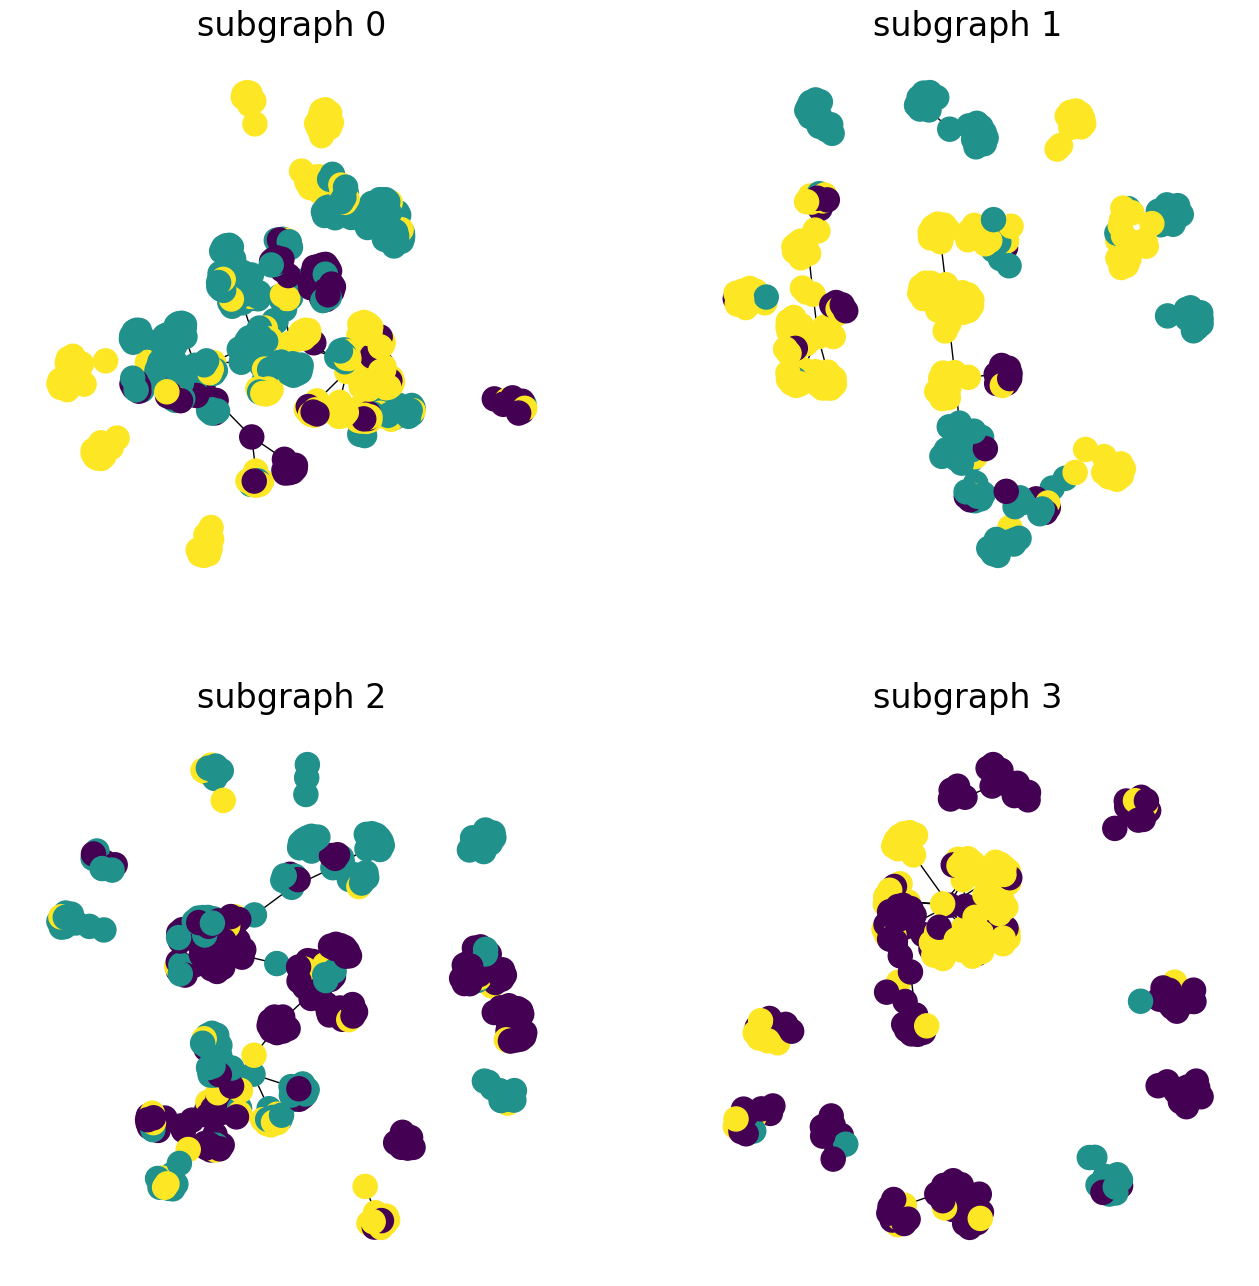

In [ ]:
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig=plt.figure(figsize=(16,16))
for idx, (subdata,pos) in enumerate(zip(train_loader,[221,222,223,224])):
    G=to_networkx(subdata,to_undirected=True)
    ax=fig.add_subplot(pos)
    ax.set_title(f'subgraph {idx}', fontsize=24)
    plt.axis('off')
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=False,
                     node_color=subdata.y)
plt.show()

In [30]:
class GraphSAGE(nn.Module):
    def __init__(self,dim_in,dim_h,dim_out):
        super().__init__()
        self.sage1=SAGEConv(dim_in,dim_h)
        self.sage2=SAGEConv(dim_h,dim_out)
        self.relu=nn.ReLU()
        self.accuracy=Accuracy(task='multiclass',num_classes=3)

    def forward(self,x, edge_index):
        h=self.sage1(x,edge_index)
        h=self.relu(h)
        h=F.dropout(h, p=0.5,training=self.training)
        h=self.sage2(h,edge_index)
        return F.log_softmax(h,dim=1)
    
    def fit(self,data,epochs):
        criterion=nn.CrossEntropyLoss()
        optim=torch.optim.Adam(self.parameters(),lr=0.01)
        self.train()
        for epoch in range(epochs+1):
            total_loss,val_loss,acc,val_acc=0,0,0,0

            for batch in train_loader:
                optim.zero_grad()
                out=self(batch.x,batch.edge_index)
                loss=criterion(out[batch.train_mask],batch.y[batch.train_mask])
                total_loss+=loss
                predict=out[batch.train_mask].argmax(dim=1)
                gt=batch.y[batch.train_mask]
                acc+=self.accuracy(predict,gt)
                loss.backward()
                optim.step()

                #validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += self.accuracy(out[batch.val_mask].argmax(dim=1),batch.y[batch.val_mask])
                

                if epoch %20 ==0:
                    print(f'Epoch {epoch:>3}, train loss : {loss/len(train_loader):.3f}, train acc :{acc/len(train_loader)*100:>6.2f}%,\
                        val loss : {val_loss/len(train_loader):.2f}, val acc : {val_acc/len(train_loader)*100:.2f}%')
                    
    @torch.no_grad()
    def test(self,data):
        self.eval()
        out=self(data.x,data.edge_index)
        acc=self.accuracy(out.argmax(dim=1)[data.test_mask],data.y[data.test_mask])
        return acc 


In [31]:
graphsage=GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)
graphsage.fit(data,200)

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
  (relu): ReLU()
  (accuracy): MulticlassAccuracy()
)
Epoch   0, train loss : 0.275, train acc :  4.41%,                        val loss : 0.28, val acc : 6.25%
Epoch   0, train loss : 0.269, train acc : 18.47%,                        val loss : 0.55, val acc : 21.88%
Epoch   0, train loss : 0.283, train acc : 21.42%,                        val loss : 0.83, val acc : 23.54%
Epoch   0, train loss : 0.301, train acc : 21.42%,                        val loss : 1.12, val acc : 23.54%
Epoch  20, train loss : 0.002, train acc : 25.00%,                        val loss : 0.21, val acc : 16.07%
Epoch  20, train loss : 0.002, train acc : 50.00%,                        val loss : 0.43, val acc : 32.74%
Epoch  20, train loss : 0.002, train acc : 75.00%,                        val loss : 0.61, val acc : 47.74%
Epoch  20, train loss : 0.003, train acc :100.00%,                        val loss : 0.70, val acc : 6

In [32]:
acc=graphsage.test(data)
print(f'graphsage test acc: {acc*100:.2f}%')


graphsage test acc: 76.20%


In [3]:
from torch_geometric.datasets import PPI
from torch_geometric.data import Batch
from torch_geometric.loader import NeighborLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphSAGE
from sklearn.metrics import f1_score

In [4]:

train_dataset=PPI(root='E:/glass_git/ML-DL/Graph/data', split='train')
val_dataset=PPI(root='E:/glass_git/ML-DL/Graph/data', split='val')
test_dataset=PPI(root='E:/glass_git/ML-DL/Graph/data', split='test')


In [5]:
train_dataset.data

e:\glass_git\ML-DL\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[44906, 50], edge_index=[2, 1226368], y=[44906, 121])

In [6]:
train_dataset.data.x[0]

tensor([-0.0855, -0.0884, -0.1128, -0.1719, -0.0766, -0.1003, -0.0751, -0.1149,
        -0.1212, -0.0994,  0.0000, -0.1699, -0.0428, -0.1123, -0.0760, -0.1152,
        -0.1031, -0.1120, -0.1435, -0.0975, -0.0875, -0.1457, -0.1234, -0.1242,
        -0.0976, -0.1197, -0.1161, -0.0735, -0.0667, -0.0873, -0.1797, -0.1447,
        -0.1606, -0.1582, -0.1477, -0.4350, -0.1617, -0.1556, -0.1526, -0.1396,
        -0.1281, -0.1539, -0.1593, -0.1546, -0.1466, -0.1449, -0.1568, -0.1399,
        -0.1494, -0.1481])

In [7]:
train_dataset.data.y[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.])

In [8]:
train_data=Batch.from_data_list(train_dataset)
loader=NeighborLoader(train_data,\
                      batch_size=2048,\
                      shuffle=True,
                       num_neighbors=[20,10],
                       num_workers=2,
                       persistent_workers=True)


In [11]:
train_loader=DataLoader(train_dataset,batch_size=2)
val_loader=DataLoader(val_dataset,batch_size=2)
test_loader=DataLoader(test_dataset,batch_size=2)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    num_layers=2,
    out_channels=train_dataset.num_classes
).to(device)

criterion=nn.BCEWithLogitsLoss()
optim=torch.optim.Adam(model.parameters(), lr=0.005)

def fit():
    model.train()
    total_loss=0
    for data in train_loader:
        data=data.to(device)
        optim.zero_grad()
        out=model(data.x, data.edge_index)
        loss=criterion(out,data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optim.step()
    return total_loss/len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    data=next(iter(loader))
    out=model(data.x.to(device),data.edge_index.to(device))
    preds=(out>0).float().cpu()
    y,pred=data.y.numpy(), preds.numpy()
    return f1_score(y,pred,average='micro') if pred.sum() >0 else 0

for epoch in range(301):
    loss=fit()
    val_f1=test(val_loader)
    if epoch %50 ==0:
        print(f'epoch: {epoch}, train loss: {loss:.3f}, val f1-score: {val_f1:.3f}')

print(f"test f1 score: {test(test_loader):.3f}")


epoch: 0, train loss: 0.590, val f1-score: 0.412
epoch: 50, train loss: 0.197, val f1-score: 0.834
epoch: 100, train loss: 0.145, val f1-score: 0.878
epoch: 150, train loss: 0.126, val f1-score: 0.889
epoch: 200, train loss: 0.108, val f1-score: 0.904
epoch: 250, train loss: 0.102, val f1-score: 0.908
epoch: 300, train loss: 0.093, val f1-score: 0.912
test f1 score: 0.931


In [ ]:
#단일 파일 read 코드
import pickle
import numpy as np
import scipy.sparse as sp

with open('E:/glass_git/ML-DL/Graph/data/Pubmed/raw/'+"ind.pubmed.allx", "rb") as f:
    allx = pickle.load(f, encoding="latin1")

allx.shape

(18717, 500)